In [2]:
!pip install torch torchvision

In [3]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST, CIFAR10
import matplotlib.pyplot as plt
import numpy as np
import torchvision


In [4]:
cifar_trainset_temp = CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Create a DataLoader
data_loader = DataLoader(cifar_trainset_temp, batch_size=len(cifar_trainset_temp), shuffle=False)

# Compute mean and std
data = next(iter(data_loader))[0]
mean_cifar = torch.mean(data, dim=[0, 2, 3])
std_cifar = torch.std(data, dim=[0, 2, 3])

print(mean_cifar, std_cifar)

100%|██████████| 170498071/170498071 [00:02<00:00, 67416456.94it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
tensor([0.4914, 0.4822, 0.4465]) tensor([0.2470, 0.2435, 0.2616])


In [6]:
# Transform for CIFAR-10 using its mean and std
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_cifar, std_cifar)
])

# Transform for FashionMNIST. Here we are using 0.5 as it scales data between [-1, 1]

transform_fmnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#transform_fmnist = transforms.Compose([transforms.ToTensor()])
trainset_fmnist = FashionMNIST(root='./data', train=True, download=True, transform=transform_fmnist)
testset_fmnist = FashionMNIST(root='./data', train=False, download=True, transform=transform_fmnist)

trainset_cifar = CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
testset_cifar = CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)


100%|██████████| 26421880/26421880 [00:01<00:00, 20464683.35it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 341970.09it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6060999.42it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15635247.64it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Files already downloaded and verified
Files already downloaded and verified


In [7]:
print("Fashion MNIST image shape:", trainset_fmnist[0][0].shape)
print("CIFAR-10 image shape:", trainset_cifar[0][0].shape)


Fashion MNIST image shape: torch.Size([1, 28, 28])
CIFAR-10 image shape: torch.Size([3, 32, 32])


In [ ]:
print("Number of images in Fashion MNIST trainset:", len(trainset_fmnist))
print("Number of images in Fashion MNIST testset:", len(testset_fmnist))
print("Number of images in CIFAR-10 trainset:", len(trainset_cifar))
print("Number of images in CIFAR-10 testset:", len(testset_cifar))


Number of images in Fashion MNIST trainset: 60000
Number of images in Fashion MNIST testset: 10000
Number of images in CIFAR-10 trainset: 50000
Number of images in CIFAR-10 testset: 10000


Sample images from Fashion MNIST:


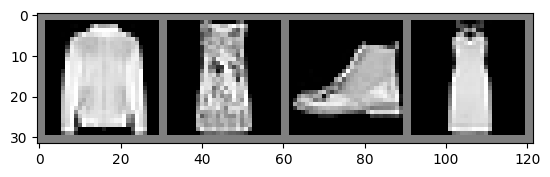

Sample images from CIFAR-10:


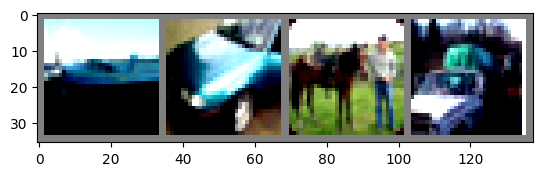

In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# Get some random training images from Fashion MNIST
dataiter_fmnist = iter(DataLoader(trainset_fmnist, batch_size=4, shuffle=True))
images_fmnist, labels_fmnist = next(dataiter_fmnist)

# Show images
print("Sample images from Fashion MNIST:")
imshow(torchvision.utils.make_grid(images_fmnist))

# Get some random training images from CIFAR-10
dataiter_cifar = iter(DataLoader(trainset_cifar, batch_size=4, shuffle=True))
images_cifar, labels_cifar = next(dataiter_cifar)

# Show images
print("Sample images from CIFAR-10:")
imshow(torchvision.utils.make_grid(images_cifar))



In [8]:
def flatten_dataset(dataset):
    data, targets = [], []
    for img, label in dataset:
        data.append(img.view(-1))
        targets.append(label)
    return torch.stack(data), torch.tensor(targets)

train_data_fmnist, train_labels_fmnist = flatten_dataset(trainset_fmnist)
test_data_fmnist, test_labels_fmnist = flatten_dataset(testset_fmnist)

train_data_cifar, train_labels_cifar = flatten_dataset(trainset_cifar)
test_data_cifar, test_labels_cifar = flatten_dataset(testset_cifar)


In [ ]:
import numpy as np

class MLP:
    def __init__(self, layer_sizes, activation_functions, initialization_methods, learning_rate=0.01, lambda_l1=0.0, lambda_l2=0.0):
        assert len(layer_sizes) - 1 == len(activation_functions)
        #每层（除输入层）都需要指定一个激活函数
        self.layer_sizes = layer_sizes
        self.activation_functions = activation_functions
        self.initialization_methods = initialization_methods
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []
        self.initialize_weights_and_biases()
        self.training_curve = []
        #正则化系数
        self.lambda_l1 = lambda_l1
        self.lambda_l2 = lambda_l2
    def initialize_weights_and_biases(self):
        for i in range(len(self.layer_sizes) - 1):
            init_method = self.initialization_methods[i]
            if init_method == "zeros":
                self.weights.append(np.zeros((self.layer_sizes[i], self.layer_sizes[i + 1])))
            elif init_method == "uniform":
                self.weights.append(np.random.uniform(-1, 1, (self.layer_sizes[i], self.layer_sizes[i + 1])))
            elif init_method == "gaussian":
                self.weights.append(np.random.randn(self.layer_sizes[i], self.layer_sizes[i + 1]))
            elif init_method == "xavier":
                self.weights.append(np.random.randn(self.layer_sizes[i], self.layer_sizes[i + 1]) * np.sqrt(2 / (self.layer_sizes[i] + self.layer_sizes[i + 1])))
            elif init_method == "kaiming":
                self.weights.append(np.random.randn(self.layer_sizes[i], self.layer_sizes[i + 1]) * np.sqrt(2. / (self.layer_sizes[i])))
            else:
                raise ValueError(f"Unknown initialization method for layer {i+1}!")

            self.biases.append(np.zeros((1, self.layer_sizes[i + 1])))

    def activation(self, z, activation_function):
        if activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-z))
        elif activation_function == 'relu':
            return np.maximum(0, z)
        elif activation_function == 'tanh':
            return np.tanh(z)
        elif activation_function == 'softmax':
            exps = np.exp(z - np.max(z, axis=1, keepdims=True))
            return exps / np.sum(exps, axis=1, keepdims=True)
        else:
            raise ValueError('Unknown activation function: {}'.format(activation_function))

    def derivative_activation(self, a, activation_function):
        if activation_function == 'relu':
            return np.where(a > 0, 1, 0)
        elif activation_function == 'sigmoid':
            return a * (1 - a)
        elif activation_function == 'tanh':
            return 1 - np.square(a)
        else:
            raise ValueError(f"未知的激活函数: {activation_function}")

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        loss = -np.sum(y_true * np.log(y_pred)) / m
        l1_loss = self.lambda_l1 * np.sum([np.sum(np.abs(w)) for w in self.weights]) / (2 * m)
        l2_loss = self.lambda_l2 * np.sum([np.sum(np.square(w)) for w in self.weights]) / (2 * m)
        total_loss = loss + l1_loss + l2_loss
        return total_loss

    def forward(self, X):
        self.a = [X]
        self.z = []
        for i in range(len(self.weights)):
            z = np.dot(self.a[-1], self.weights[i]) + self.biases[i]
            self.z.append(z)
            a = self.activation(z, self.activation_functions[i])
            self.a.append(a)
        return a

    def backward(self, X, y):
        m = X.shape[0]
        dz = self.a[-1] - y  # 输出层的 dz
        for i in range(len(self.weights) - 1, -1, -1):
            L = (self.lambda_l1 * np.sign(self.weights[i]) + self.lambda_l2 * self.weights[i]) / m
            dw = np.dot(self.a[i].T, dz) / m
            db = np.sum(dz, axis=0, keepdims=True) / m
            self.weights[i] -= self.learning_rate * dw
            self.biases[i] -= self.learning_rate * db
            if i > 0:
                da = np.dot(dz, self.weights[i].T)
                dz = da * self.derivative_activation(self.a[i], self.activation_functions[i - 1])

    def train(self, X, y, epochs):
        for _ in range(epochs):
            predictions = self.forward(X)
            loss = self.compute_loss(y, predictions)
            self.training_curve.append(loss)
            self.backward(X, y)

    def predict(self, X):
        probabilities = self.forward(X)
        predictions = np.argmax(probabilities, axis=1)
        return predictions

    def plot_training_curve(self):
        plt.plot(self.training_curve)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Curve')
        plt.show()

In [ ]:
def calculate_accuracy(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError("The length of y_true and y_pred must be the same")

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    correct_predictions = np.sum(y_true == y_pred)
    total_predictions = len(y_true)

    accuracy = correct_predictions / total_predictions

    return accuracy

In [ ]:
#3.1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
transform = transforms.Compose([transforms.ToTensor()])
train_set = FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [ ]:
train_num = 512
test_num = 128
train_loader = DataLoader(train_set, batch_size=train_num, shuffle=True)
test_loader = DataLoader(test_set, batch_size=test_num, shuffle=False)
# train
dataiter = iter(train_loader)
train_images, train_labels = next(dataiter)
train_images = train_images.view(train_num, 1, 784)
train_images = train_images[:, 0, :]
train_images = train_images.numpy()
train_labels = train_labels.numpy()

train_labels = np.eye(10)[train_labels]

# test
dataiter = iter(test_loader)
test_images, test_labels = next(dataiter)
test_images = test_images.view(test_num, 1, 784)
test_images = test_images[:, 0, :]
test_images = test_images.numpy()
test_labels = test_labels.numpy()


In [ ]:
test_images

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.04313726,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

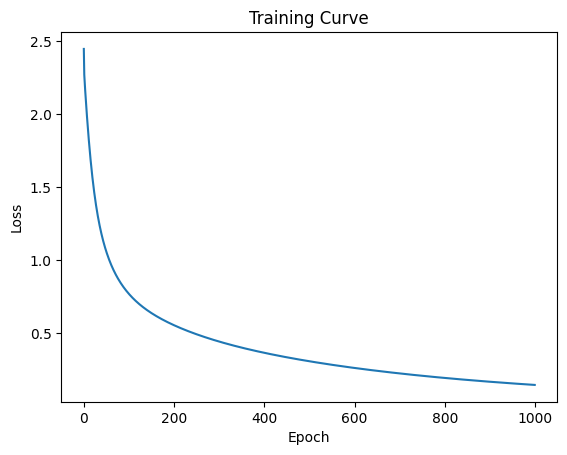

0.8125

In [ ]:
layer_sizes = [784, 128, 10]
activation_functions = ['sigmoid', 'softmax']
initialization_methods = ['xavier', 'xavier']
learning_rate = 0.2

mlp = MLP(layer_sizes, activation_functions, initialization_methods, learning_rate,0.3,0)
mlp.train(train_images, train_labels, epochs=1000)
mlp.plot_training_curve()
predictions = mlp.predict(test_images)
accuracy = calculate_accuracy(test_labels,predictions)
accuracy

In [ ]:
initialization_methods_list = ["zeros", "uniform", "gaussian", "xavier", "kaiming"]

training_curves = {}
test_accuracies = {}
learning_rate = 0.1
for init_method in initialization_methods_list:
    # Reset MLP with desired weight initialization
    mlp = MLP(layer_sizes, activation_functions, [init_method, init_method], learning_rate, 0.3, 0)
    mlp.train(train_images, train_labels, epochs=1000)

    predictions = mlp.predict(test_images)
    accuracy = calculate_accuracy(test_labels, predictions)

    training_curves[init_method] = mlp.training_curve
    test_accuracies[init_method] = accuracy


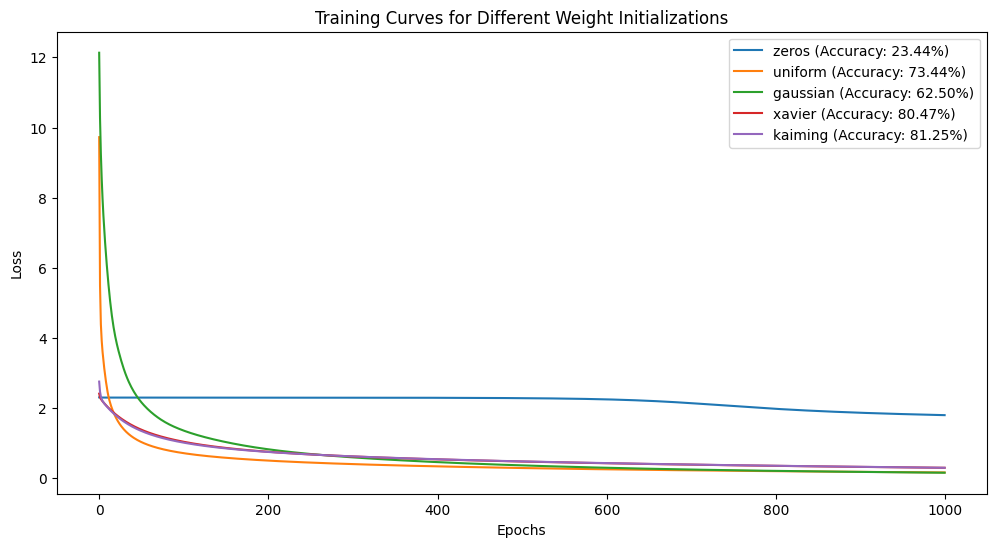

In [ ]:
plt.figure(figsize=(12, 6))

for init_method, curve in training_curves.items():
    plt.plot(curve, label=f"{init_method} (Accuracy: {test_accuracies[init_method]:.2%})")

plt.title('Training Curves for Different Weight Initializations')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [ ]:
#3.1 attempt

# Reshape and convert the dataset to numpy arrays
X_train_fmnist = trainset_fmnist.data.numpy().reshape(-1, 784) / 255.0  # Normalize data to [0, 1]
y_train_fmnist = trainset_fmnist.targets.numpy()

X_test_fmnist = testset_fmnist.data.numpy().reshape(-1, 784) / 255.0  # Normalize data to [0, 1]
y_test_fmnist = testset_fmnist.targets.numpy()

# Convert labels to one-hot encoding
y_train_fmnist_onehot = np.eye(10)[y_train_fmnist]
y_test_fmnist_onehot = np.eye(10)[y_test_fmnist]


In [ ]:
initialization_methods = ["zeros", "uniform", "gaussian", "xavier", "kaiming"]
mlps = {}
for init_method in initialization_methods:
    print(f"Training with {init_method} initialization...")
    mlp = MLP(layer_sizes=[784, 128, 10],
              activation_functions=['relu', 'softmax'],
              initialization_methods=[init_method, "xavier"],
              learning_rate=0.01)
    mlp.train(X_train_fmnist, y_train_fmnist_onehot, epochs=100)
    mlps[init_method] = mlp


Training with zeros initialization...
Training with uniform initialization...
Training with gaussian initialization...
Training with xavier initialization...
Training with kaiming initialization...


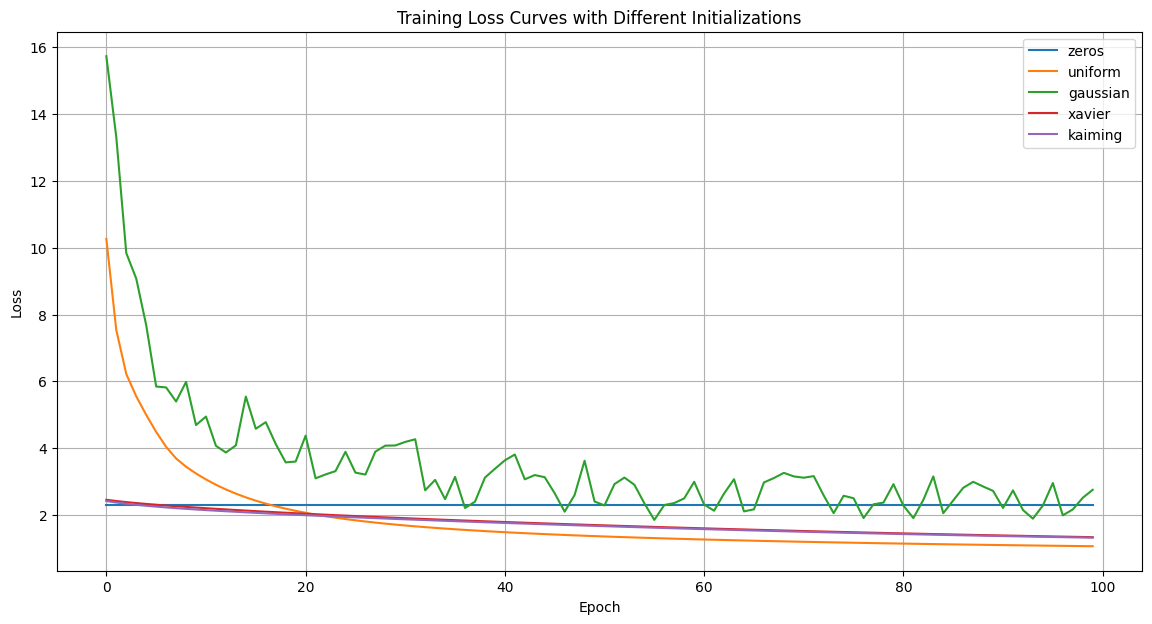

Test accuracy with zeros initialization: 10.00%
Test accuracy with uniform initialization: 64.84%
Test accuracy with gaussian initialization: 66.12%
Test accuracy with xavier initialization: 63.47%
Test accuracy with kaiming initialization: 63.45%


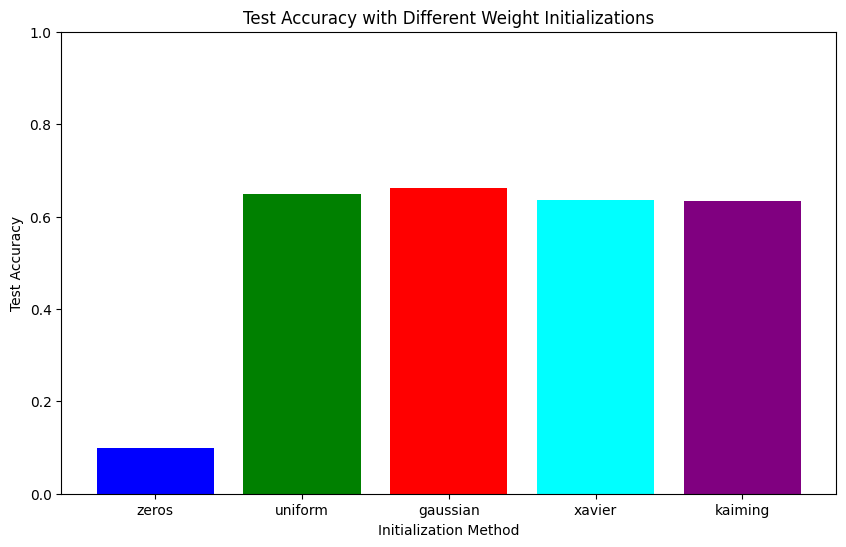

In [ ]:
plt.figure(figsize=(14, 7))
for init_method, mlp in mlps.items():
    plt.plot(mlp.training_curve, label=init_method)

plt.title("Training Loss Curves with Different Initializations")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Comparing Test Accuracies
test_accuracies = {}
for init_method, mlp in mlps.items():
    y_pred = mlp.predict(X_test_fmnist)
    acc = calculate_accuracy(y_test_fmnist, y_pred)
    test_accuracies[init_method] = acc
    print(f"Test accuracy with {init_method} initialization: {acc*100:.2f}%")

# Plotting the test accuracies
plt.figure(figsize=(10, 6))
plt.bar(test_accuracies.keys(), test_accuracies.values(), color=['blue', 'green', 'red', 'cyan', 'purple'])
plt.xlabel("Initialization Method")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy with Different Weight Initializations")
plt.ylim([0, 1])
plt.show()


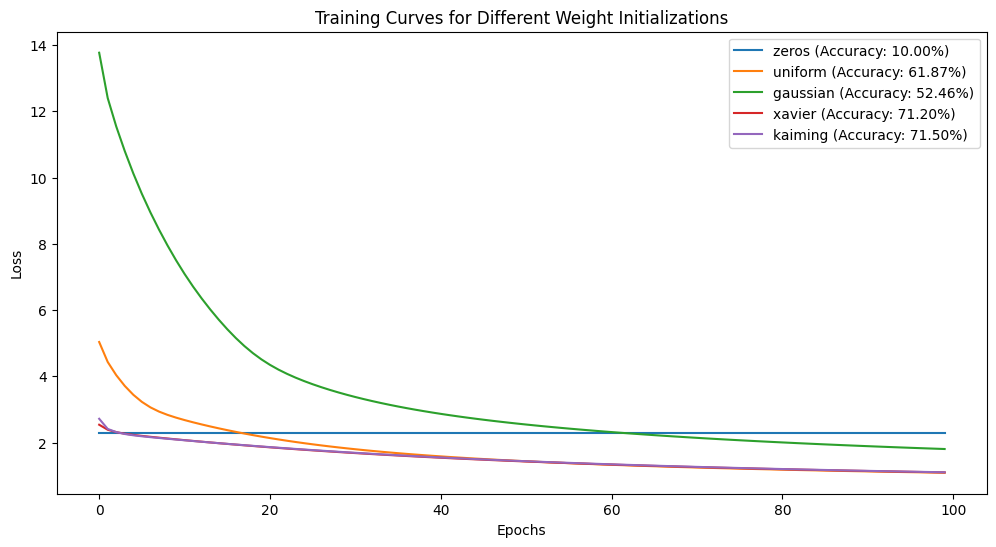

In [ ]:
# Setup dataset and DataLoader
transform = transforms.Compose([transforms.ToTensor()])
train_set = FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=len(train_set), shuffle=True)
test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=False)

# Load entire train dataset
train_images, train_labels = next(iter(train_loader))
train_images = train_images.view(len(train_set), 784).numpy()
train_labels = np.eye(10)[train_labels.numpy()]

# Load entire test dataset
test_images, test_labels = next(iter(test_loader))
test_images = test_images.view(len(test_set), 784).numpy()

# MLP settings
layer_sizes = [784, 128, 10]
activation_functions = ['sigmoid', 'softmax']
learning_rate = 0.1

# Train and evaluate MLP for different initializations
initialization_methods_list = ["zeros", "uniform", "gaussian", "xavier", "kaiming"]
training_curves = {}
test_accuracies = {}

for init_method in initialization_methods_list:
    mlp = MLP(layer_sizes, activation_functions, [init_method, init_method], learning_rate)
    mlp.train(train_images, train_labels, epochs=100)

    predictions = mlp.predict(test_images)
    accuracy = calculate_accuracy(test_labels, predictions)

    training_curves[init_method] = mlp.training_curve
    test_accuracies[init_method] = accuracy

# Plotting the results
plt.figure(figsize=(12, 6))
for init_method, curve in training_curves.items():
    plt.plot(curve, label=f"{init_method} (Accuracy: {test_accuracies[init_method]:.2%})")

plt.title('Training Curves for Different Weight Initializations')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Training No hidden layers model...
Training One hidden layer model...
Training Two hidden layers model...


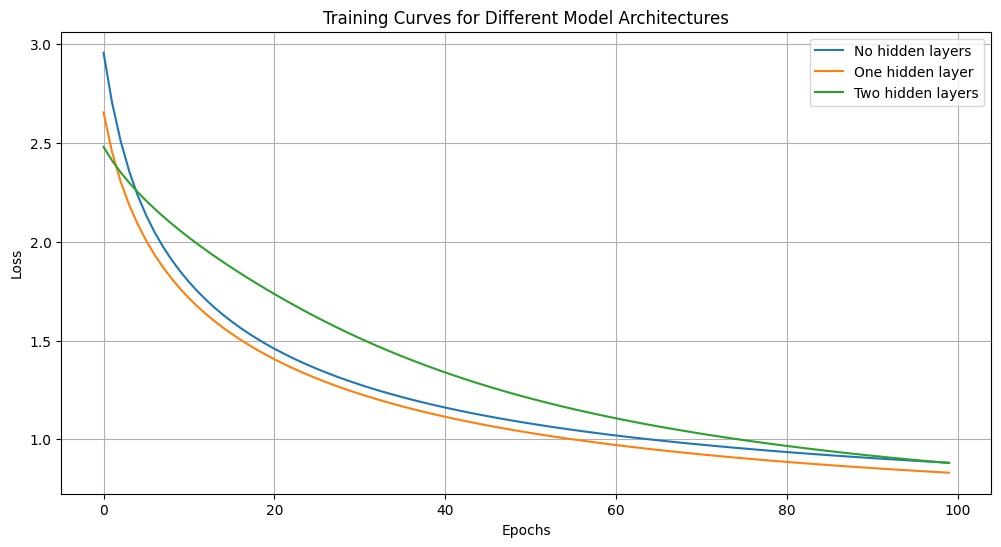

Accuracy of model No hidden layers: 70.49%
Accuracy of model One hidden layer: 72.54%
Accuracy of model Two hidden layers: 72.72%


In [ ]:
# 3.2
# Convert PyTorch tensors to numpy arrays for compatibility
train_data_fmnist_np = train_data_fmnist.numpy()
train_labels_fmnist_np = train_labels_fmnist.numpy()
test_data_fmnist_np = test_data_fmnist.numpy()
test_labels_fmnist_np = test_labels_fmnist.numpy()

# Model 1: No hidden layers
mlp_1 = MLP(
    layer_sizes=[784, 10],
    activation_functions=['softmax'],
    initialization_methods=['xavier']
)

# Model 2: One hidden layer with 128 units
mlp_2 = MLP(
    layer_sizes=[784, 128, 10],
    activation_functions=['relu', 'softmax'],
    initialization_methods=['xavier', 'xavier']
)

# Model 3: Two hidden layers, each with 128 units
mlp_3 = MLP(
    layer_sizes=[784, 128, 128, 10],
    activation_functions=['relu', 'relu', 'softmax'],
    initialization_methods=['xavier', 'xavier', 'xavier']
)

models = {'No hidden layers': mlp_1, 'One hidden layer': mlp_2, 'Two hidden layers': mlp_3}

# Training
epochs = 100
training_curves_combined = {}  # store the training curves for all models

for name, model in models.items():
    print(f"Training {name} model...")
    targets_onehot = np.eye(10)[train_labels_fmnist_np]
    model.train(train_data_fmnist_np, targets_onehot, epochs)
    training_curves_combined[name] = model.training_curve

# Plotting combined training curves
plt.figure(figsize=(12, 6))
for name, curve in training_curves_combined.items():
    plt.plot(curve, label=name)

plt.title('Training Curves for Different Model Architectures')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
accuracies = {}
for name, model in models.items():
    predictions = model.predict(test_data_fmnist_np)
    accuracy = calculate_accuracy(test_labels_fmnist_np, predictions)
    accuracies[name] = accuracy

for name, acc in accuracies.items():
    print(f"Accuracy of model {name}: {acc*100:.2f}%")


In [ ]:
test_loader = DataLoader(test_set, batch_size=test_num, shuffle=False)

print(test_images.shape)


(128, 784)


Training No hidden layers model...
Training One hidden layer model...
Training Two hidden layers model...


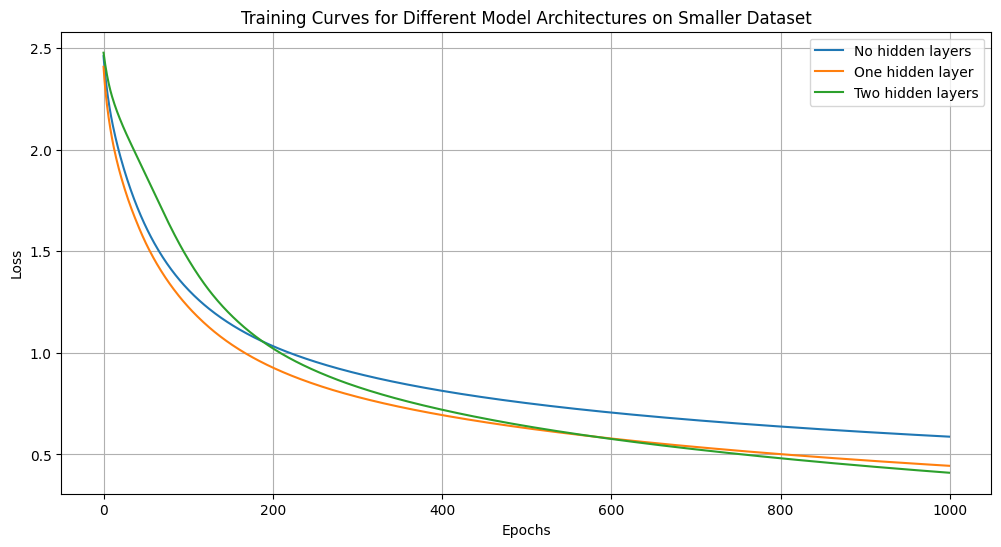

In [ ]:
# Define models

models = {
    'No hidden layers': MLP(
        layer_sizes=[784, 10],
        activation_functions=['softmax'],
        initialization_methods=['xavier']
    ),
    'One hidden layer': MLP(
        layer_sizes=[784, 128, 10],
        activation_functions=['relu', 'softmax'],
        initialization_methods=['xavier', 'xavier']
    ),
    'Two hidden layers': MLP(
        layer_sizes=[784, 128, 128, 10],
        activation_functions=['relu', 'relu', 'softmax'],
        initialization_methods=['xavier', 'xavier', 'xavier']
    )
}

# Training
epochs = 1000
training_curves_combined = {}  # store the training curves for all models

for name, model in models.items():
    print(f"Training {name} model...")
    model.train(train_images, train_labels, epochs)
    training_curves_combined[name] = model.training_curve

# Plotting combined training curves
plt.figure(figsize=(12, 6))
for name, curve in training_curves_combined.items():
    plt.plot(curve, label=name)

plt.title('Training Curves for Different Model Architectures on Smaller Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()




Training ReLU model...
Training Sigmoid model...
Training Tanh model...


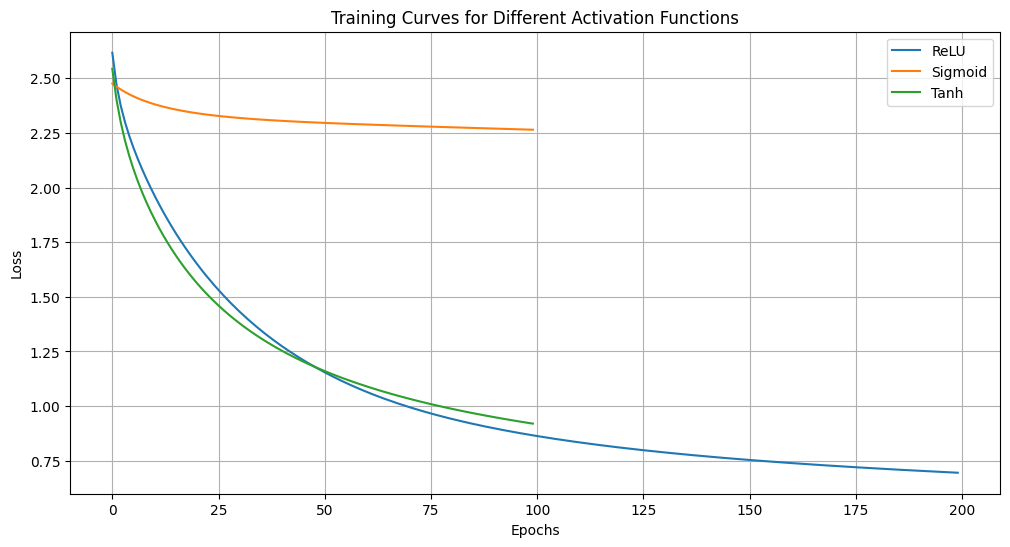

Accuracy of model with ReLU activations: 75.70%
Accuracy of model with Sigmoid activations: 23.93%
Accuracy of model with Tanh activations: 72.31%


In [ ]:
# 3.3

# Create a copy of the MLP with sigmoid activations for the hidden layers
mlp_sigmoid = MLP(
    layer_sizes=[784, 128, 128, 10],
    activation_functions=['sigmoid', 'sigmoid', 'softmax'],
    initialization_methods=['xavier', 'xavier', 'xavier']
)

# Create a copy of the MLP with tanh activations for the hidden layers
mlp_tanh = MLP(
    layer_sizes=[784, 128, 128, 10],
    activation_functions=['tanh', 'tanh', 'softmax'],
    initialization_methods=['xavier', 'xavier', 'xavier']
)

# Models to train and evaluate
models_to_evaluate = {
    'ReLU': mlp_3,  # Using the mlp_3 model from before
    'Sigmoid': mlp_sigmoid,
    'Tanh': mlp_tanh
}

# Store the training curves
training_curves = {}

# Training
epochs = 100
for name, model in models_to_evaluate.items():
    print(f"Training {name} model...")
    targets_onehot = np.eye(10)[train_labels_fmnist_np]
    model.train(train_data_fmnist_np, targets_onehot, epochs)
    training_curves[name] = model.training_curve

# Plotting the training curves
plt.figure(figsize=(12, 6))
for name, curve in training_curves.items():
    plt.plot(curve, label=name)

plt.title('Training Curves for Different Activation Functions')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Evaluation
accuracies = {}
for name, model in models_to_evaluate.items():
    predictions = model.predict(test_data_fmnist_np)
    accuracy = calculate_accuracy(test_labels_fmnist_np, predictions)
    accuracies[name] = accuracy

for name, acc in accuracies.items():
    print(f"Accuracy of model with {name} activations: {acc*100:.2f}%")


Training ReLU model...
Training Sigmoid model...
Training Tanh model...


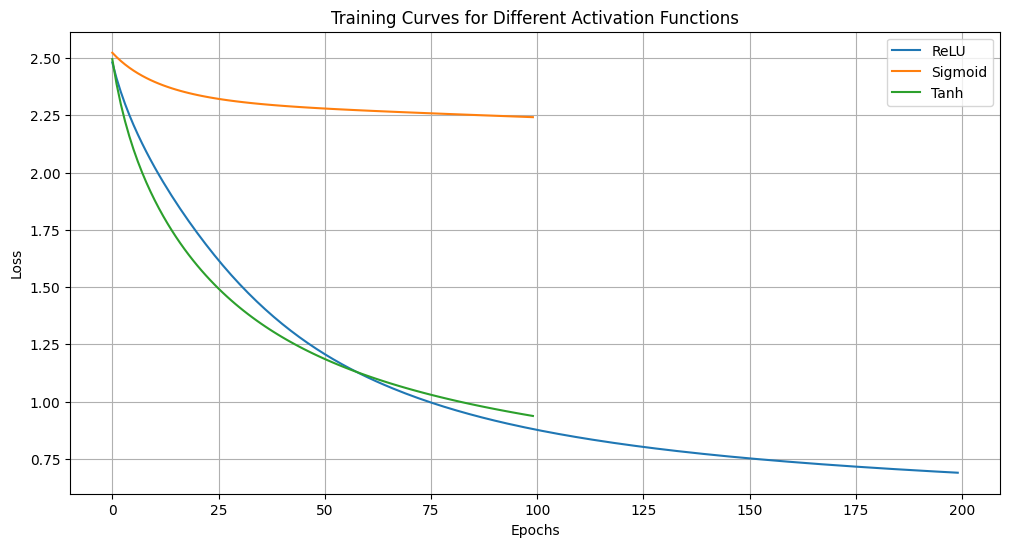

Accuracy of model with ReLU activations: 76.10%
Accuracy of model with Sigmoid activations: 38.04%
Accuracy of model with Tanh activations: 71.63%


In [ ]:
# 3.3
# why do we have ReLU all the way to 200 :/ ?
# Create a copy of the MLP with ReLU activations for the hidden layers
mlp_relu = MLP(
    layer_sizes=[784, 128, 128, 10],
    activation_functions=['relu', 'relu', 'softmax'],
    initialization_methods=['xavier', 'xavier', 'xavier']
)

# Create a copy of the MLP with sigmoid activations for the hidden layers
mlp_sigmoid = MLP(
    layer_sizes=[784, 128, 128, 10],
    activation_functions=['sigmoid', 'sigmoid', 'softmax'],
    initialization_methods=['xavier', 'xavier', 'xavier']
)

# Create a copy of the MLP with tanh activations for the hidden layers
mlp_tanh = MLP(
    layer_sizes=[784, 128, 128, 10],
    activation_functions=['tanh', 'tanh', 'softmax'],
    initialization_methods=['xavier', 'xavier', 'xavier']
)

# Models to train and evaluate
models_to_evaluate = {
    'ReLU': mlp_3,  # Using the mlp_3 model from before
    'Sigmoid': mlp_sigmoid,
    'Tanh': mlp_tanh
}

# Store the training curves
training_curves = {}

# Training
epochs = 100
for name, model in models_to_evaluate.items():
    print(f"Training {name} model...")
    targets_onehot = np.eye(10)[train_labels_fmnist_np]
    model.train(train_data_fmnist_np, targets_onehot, epochs)
    training_curves[name] = model.training_curve

# Plotting the training curves
plt.figure(figsize=(12, 6))
for name, curve in training_curves.items():
    plt.plot(curve, label=name)

plt.title('Training Curves for Different Activation Functions')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Evaluation
accuracies = {}
for name, model in models_to_evaluate.items():
    predictions = model.predict(test_data_fmnist_np)
    accuracy = calculate_accuracy(test_labels_fmnist_np, predictions)
    accuracies[name] = accuracy

for name, acc in accuracies.items():
    print(f"Accuracy of model with {name} activations: {acc*100:.2f}%")



In [ ]:
def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels]

In [ ]:
# 3.4

# Convert the PyTorch tensors to numpy arrays
train_data_fmnist_np = train_data_fmnist.numpy()
train_labels_fmnist_np = train_labels_fmnist.numpy()
test_data_fmnist_np = test_data_fmnist.numpy()
test_labels_fmnist_np = test_labels_fmnist.numpy()

# Convert target labels to one-hot encoding
train_labels_fmnist_onehot = one_hot_encode(train_labels_fmnist_np)

layer_sizes = [784, 128, 128, 10]
activation_functions = ['relu', 'relu', 'softmax']
initialization_methods = ['xavier', 'xavier', 'xavier']

epochs = 100

# 1. Train with L1 regularization
model_L1 = MLP(layer_sizes=layer_sizes,
               activation_functions=activation_functions,
               initialization_methods=initialization_methods,
               learning_rate=0.01,
               lambda_l1=0.01,  # L1 regularization
               lambda_l2=0.0)
model_L1.train(train_data_fmnist_np, train_labels_fmnist_onehot, epochs)

# 2. Train with L2 regularization
model_L2 = MLP(layer_sizes=layer_sizes,
               activation_functions=activation_functions,
               initialization_methods=initialization_methods,
               learning_rate=0.01,
               lambda_l1=0.0,
               lambda_l2=0.01)  # L2 regularization
model_L2.train(train_data_fmnist_np, train_labels_fmnist_onehot, epochs)

# Evaluate accuracy for both models
def accuracy(predictions, labels):
    return np.mean(predictions == labels)

predictions_L1 = model_L1.predict(test_data_fmnist_np)
predictions_L2 = model_L2.predict(test_data_fmnist_np)

accuracy_L1 = accuracy(predictions_L1, test_labels_fmnist_np)
accuracy_L2 = accuracy(predictions_L2, test_labels_fmnist_np)

print(f"Accuracy with L1 regularization: {accuracy_L1*100:.2f}%")
print(f"Accuracy with L2 regularization: {accuracy_L2*100:.2f}%")


Accuracy with L1 regularization: 70.71%
Accuracy with L2 regularization: 72.07%


In [ ]:
# 3.5
transform_unnormalized = transforms.Compose([transforms.ToTensor()])
trainset_fmnist_unnormalized = FashionMNIST(root='./data', train=True, download=True, transform=transform_unnormalized)
testset_fmnist_unnormalized = FashionMNIST(root='./data', train=False, download=True, transform=transform_unnormalized)

train_data_fmnist_unnorm, train_labels_fmnist_unnorm = flatten_dataset(trainset_fmnist_unnormalized)
test_data_fmnist_unnorm, test_labels_fmnist_unnorm = flatten_dataset(testset_fmnist_unnormalized)

layer_sizes = [784, 128, 128, 10]
activation_functions = ['relu', 'relu', 'softmax']
initialization_methods = ['xavier', 'xavier', 'xavier']
learning_rate = 0.01
epochs = 100

mlp_unnormalized = MLP(layer_sizes, activation_functions, initialization_methods, learning_rate)
# Convert target labels to one-hot encoding
targets_onehot_unnorm = np.eye(10)[train_labels_fmnist_unnorm.numpy()]
mlp_unnormalized.train(train_data_fmnist_unnorm.numpy(), targets_onehot_unnorm, epochs)

predictions_unnorm = mlp_unnormalized.predict(test_data_fmnist_unnorm.numpy())
accuracy_unnorm = np.mean(predictions_unnorm == test_labels_fmnist_unnorm.numpy())
print(f"Accuracy on unnormalized data: {accuracy_unnorm * 100:.2f}%")


mlp_normalized = MLP(layer_sizes, activation_functions, initialization_methods, learning_rate)
# Convert target labels to one-hot encoding
targets_onehot_norm = np.eye(10)[train_labels_fmnist.numpy()]

mlp_normalized.train(train_data_fmnist.numpy(), targets_onehot_norm, epochs)
predictions_norm = mlp_normalized.predict(test_data_fmnist.numpy())
accuracy_norm = np.mean(predictions_norm == test_labels_fmnist.numpy())
print(f"Accuracy on normalized data: {accuracy_norm * 100:.2f}%")


Accuracy on unnormalized data: 63.69%
Accuracy on normalized data: 71.65%


In [ ]:
# 3.5 (only 20 iterations)
transform_unnormalized = transforms.Compose([transforms.ToTensor()])
trainset_fmnist_unnormalized = FashionMNIST(root='./data', train=True, download=True, transform=transform_unnormalized)
testset_fmnist_unnormalized = FashionMNIST(root='./data', train=False, download=True, transform=transform_unnormalized)

train_data_fmnist_unnorm, train_labels_fmnist_unnorm = flatten_dataset(trainset_fmnist_unnormalized)
test_data_fmnist_unnorm, test_labels_fmnist_unnorm = flatten_dataset(testset_fmnist_unnormalized)

layer_sizes = [784, 128, 128, 10]
activation_functions = ['relu', 'relu', 'softmax']
initialization_methods = ['xavier', 'xavier', 'xavier']
learning_rate = 0.01
epochs = 20

mlp_unnormalized = MLP(layer_sizes, activation_functions, initialization_methods, learning_rate)
# Convert target labels to one-hot encoding
targets_onehot_unnorm = np.eye(10)[train_labels_fmnist_unnorm.numpy()]
mlp_unnormalized.train(train_data_fmnist_unnorm.numpy(), targets_onehot_unnorm, epochs)

predictions_unnorm = mlp_unnormalized.predict(test_data_fmnist_unnorm.numpy())
accuracy_unnorm = np.mean(predictions_unnorm == test_labels_fmnist_unnorm.numpy())
print(f"Accuracy on unnormalized data: {accuracy_unnorm * 100:.2f}%")


mlp_normalized = MLP(layer_sizes, activation_functions, initialization_methods, learning_rate)
# Convert target labels to one-hot encoding
targets_onehot_norm = np.eye(10)[train_labels_fmnist.numpy()]

mlp_normalized.train(train_data_fmnist.numpy(), targets_onehot_norm, epochs)
predictions_norm = mlp_normalized.predict(test_data_fmnist.numpy())
accuracy_norm = np.mean(predictions_norm == test_labels_fmnist.numpy())
print(f"Accuracy on normalized data: {accuracy_norm * 100:.2f}%")


Accuracy on unnormalized data: 31.18%
Accuracy on normalized data: 51.63%


In [ ]:
# 3.6

import torch.nn as nn
import torch.optim as optim

class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(7*7*64, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(kernel_size=2)(x)

        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(kernel_size=2)(x)

        x = x.view(-1, 7*7*64)

        x = self.fc1(x)
        x = nn.ReLU()(x)

        x = self.fc2(x)
        return x



In [ ]:
trainloader = torch.utils.data.DataLoader(trainset_fmnist, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset_fmnist, batch_size=64, shuffle=False)

model = FashionCNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}%")


Epoch 1, Loss: 0.4346074603164374
Epoch 2, Loss: 0.32604335637679743
Epoch 3, Loss: 0.30111238532769147
Epoch 4, Loss: 0.2937506020132667
Epoch 5, Loss: 0.2763169670124044
Epoch 6, Loss: 0.2726551053175794
Epoch 7, Loss: 0.2643090518179542
Epoch 8, Loss: 0.2593642301452376
Epoch 9, Loss: 0.2535159730278988
Epoch 10, Loss: 0.2461402697016054
Epoch 11, Loss: 0.23869539404522255
Epoch 12, Loss: 0.24162611633793377
Epoch 13, Loss: 0.23919163854407477
Epoch 14, Loss: 0.23105688169121996
Epoch 15, Loss: 0.23350613427235248
Epoch 16, Loss: 0.22852853747970386
Epoch 17, Loss: 0.2265016325096141
Epoch 18, Loss: 0.2241122763135286
Epoch 19, Loss: 0.2261838085655528
Epoch 20, Loss: 0.22714623322944716
Accuracy of the network on the 10000 test images: 89.32%


In [ ]:
# 3.7

In [ ]:
# Flatten and preprocess the CIFAR-10 dataset
train_data_cifar_np = train_data_cifar.numpy().reshape(-1, 32*32*3)
test_data_cifar_np = test_data_cifar.numpy().reshape(-1, 32*32*3)
train_labels_cifar_np = train_labels_cifar.numpy()
test_labels_cifar_np = test_labels_cifar.numpy()

# Train the MLP
mlp_cifar = MLP(layer_sizes=[32*32*3, 512, 256, 128, 10],
                activation_functions=['relu', 'relu', 'relu', 'softmax'],
                initialization_methods=['xavier', 'xavier', 'xavier', 'xavier'],
                learning_rate=0.01)

# Convert target labels to one-hot encoding
targets_onehot = np.eye(10)[train_labels_cifar_np]
mlp_cifar.train(train_data_cifar_np, targets_onehot, epochs=100)

# Evaluate the MLP
mlp_predictions = mlp_cifar.predict(test_data_cifar_np)
mlp_accuracy = np.mean(mlp_predictions == test_labels_cifar_np)
print(f"MLP Accuracy on CIFAR-10: {mlp_accuracy * 100:.2f}%")


MLP Accuracy on CIFAR-10: 35.25%


In [ ]:
import torch.nn.functional as F

# Define DataLoader for CIFAR-10
train_loader_cifar = torch.utils.data.DataLoader(trainset_cifar, batch_size=64, shuffle=True)
test_loader_cifar = torch.utils.data.DataLoader(testset_cifar, batch_size=64, shuffle=False)

# Define the CNN using PyTorch
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(8*8*64, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = self.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 8*8*64)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Training the CNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()


for epoch in range(10):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader_cifar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

# Evaluating the CNN
model.eval()
correct = 0
with torch.no_grad():
    for data, target in test_loader_cifar:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

cnn_accuracy = correct / len(test_loader_cifar.dataset)
print(f"CNN Accuracy on CIFAR-10: {cnn_accuracy * 100:.2f}%")


CNN Accuracy on CIFAR-10: 72.02%


In [ ]:
# 3.8

import time

def train_and_evaluate_model(model, optimizer, epochs=10):
    # Train
    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader_cifar):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()
        end_time = time.time()
        print(f"Epoch: {epoch + 1}, Time per epoch: {end_time - start_time:.2f} seconds")

    # Evaluate
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader_cifar:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = correct / len(test_loader_cifar.dataset)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return accuracy

# 1. SGD with momentum 0
print("Training with SGD (momentum=0)...")
model_sgd_0 = SimpleCNN().to(device)
optimizer_sgd_0 = optim.SGD(model_sgd_0.parameters(), lr=0.01, momentum=0)
train_and_evaluate_model(model_sgd_0, optimizer_sgd_0)

# 2. SGD with momentum 0.5
print("\nTraining with SGD (momentum=0.5)...")
model_sgd_05 = SimpleCNN().to(device)
optimizer_sgd_05 = optim.SGD(model_sgd_05.parameters(), lr=0.01, momentum=0.5)
train_and_evaluate_model(model_sgd_05, optimizer_sgd_05)

# 3. SGD with momentum 0.9
print("\nTraining with SGD (momentum=0.9)...")
model_sgd_09 = SimpleCNN().to(device)
optimizer_sgd_09 = optim.SGD(model_sgd_09.parameters(), lr=0.01, momentum=0.9)
train_and_evaluate_model(model_sgd_09, optimizer_sgd_09)

# 4. Adam optimizer
print("\nTraining with Adam...")
model_adam = SimpleCNN().to(device)
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)
train_and_evaluate_model(model_adam, optimizer_adam)


Training with SGD (momentum=0)...
Epoch: 1, Time per epoch: 100.16 seconds
Epoch: 2, Time per epoch: 93.61 seconds
Epoch: 3, Time per epoch: 94.62 seconds
Epoch: 4, Time per epoch: 93.48 seconds
Epoch: 5, Time per epoch: 94.51 seconds
Epoch: 6, Time per epoch: 93.49 seconds
Epoch: 7, Time per epoch: 93.19 seconds
Epoch: 8, Time per epoch: 93.45 seconds
Epoch: 9, Time per epoch: 94.19 seconds
Epoch: 10, Time per epoch: 93.48 seconds
Accuracy: 66.08%

Training with SGD (momentum=0.5)...
Epoch: 1, Time per epoch: 91.97 seconds
Epoch: 2, Time per epoch: 93.31 seconds
Epoch: 3, Time per epoch: 92.83 seconds
Epoch: 4, Time per epoch: 95.18 seconds
Epoch: 5, Time per epoch: 93.57 seconds
Epoch: 6, Time per epoch: 93.31 seconds
Epoch: 7, Time per epoch: 93.71 seconds
Epoch: 8, Time per epoch: 94.01 seconds
Epoch: 9, Time per epoch: 93.63 seconds
Epoch: 10, Time per epoch: 92.44 seconds
Accuracy: 70.42%

Training with SGD (momentum=0.9)...
Epoch: 1, Time per epoch: 92.84 seconds
Epoch: 2, Time 

0.7246

In [ ]:
# 3.9 based on whats doing well on earlier tasks, we trained this model for 100 iterations
# Normalize CIFAR-10 data
mean_cifar_np = np.mean(train_data_cifar_np, axis=0)
std_cifar_np = np.std(train_data_cifar_np, axis=0)
train_data_cifar_normalized = (train_data_cifar_np - mean_cifar_np) / std_cifar_np
test_data_cifar_normalized = (test_data_cifar_np - mean_cifar_np) / std_cifar_np

# Define the MLP with the modified parameters
mlp_cifar = MLP(layer_sizes=[32*32*3, 128, 128, 10],
                activation_functions=['relu', 'relu', 'softmax'],
                initialization_methods=['kaiming', 'kaiming', 'kaiming'],
                learning_rate=0.01)

# Convert target labels to one-hot encoding
targets_onehot = np.eye(10)[train_labels_cifar_np]

# Train the MLP
mlp_cifar.train(train_data_cifar_normalized, targets_onehot, epochs=1000)

# Evaluate the MLP
mlp_predictions = mlp_cifar.predict(test_data_cifar_normalized)
mlp_accuracy = np.mean(mlp_predictions == test_labels_cifar_np)
print(f"MLP Accuracy on CIFAR-10: {mlp_accuracy * 100:.2f}%")



MLP Accuracy on CIFAR-10: 46.71%


In [1]:
# ResNet code, it timed out many times on colab, result ran locally by Slight Chen, with accuracy
#Epoch 1，Accuracy on validation set: 93.44%
#Epoch 2，Accuracy on validation set: 93.31%
#Epoch 3，94.40%
#Epoch 4，94.30%
#Epoch 5，94.34%
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# 加载预训练的 ResNet18
resnet = models.resnet18(pretrained=True)

# 冻结所有层
for param in resnet.parameters():
    param.requires_grad = False

# 移除全连接层
num_features = resnet.fc.in_features
resnet.fc = nn.Identity()

# 添加自定义的全连接层
fc_layers = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 10)
)
resnet.fc = fc_layers

# 加载 STL10 数据集
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

train_dataset = datasets.STL10(root='./data', split='train', transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 加载验证集
test_dataset = datasets.STL10(root='./data', split='test', transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.fc.parameters(), lr=0.001)

# 训练并验证模型
for epoch in range(5):
    # 训练部分
    resnet.train()
    for inputs, labels in train_loader:
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 验证部分
    resnet.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = resnet(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}, Accuracy on validation set: {100 * correct / total:.2f}%")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 154MB/s]


  0%|          | 5570560/2640397119 [00:13<1:44:18, 421027.39it/s]


KeyboardInterrupt: ignored

In [2]:
# ResNet code, it timed out many times on colab, result ran locally by Slight Chen, with accuracy
#Epoch 1，Accuracy on validation set: 93.44%
#Epoch 2，Accuracy on validation set: 93.31%
#Epoch 3，94.40%
#Epoch 4，94.30%
#Epoch 5，94.34%

In [ ]:
# Result on another notebook file

In [ ]:
# He also did an extra task based on random dropout, in a separate notebook file.